In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "*****"
os.environ['KAGGLE_KEY'] = "*****"
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p data/


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:16<00:00, 263MB/s]
100% 1.06G/1.06G [00:16<00:00, 67.8MB/s]


In [2]:
!unzip -o data/amazon-books-reviews.zip -d data/

Archive:  data/amazon-books-reviews.zip
  inflating: data/Books_rating.csv   
  inflating: data/books_data.csv     


In [3]:
import os
import pandas as pd
from collections import Counter
from itertools import combinations
import math
import random

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Loading dataset
df = pd.read_csv("data/Books_rating.csv")
print("Rows, Cols:", df.shape)
print("Columns:", list(df.columns))

Rows, Cols: (3000000, 10)
Columns: ['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']


In [5]:
# Keeping only the columns needed for basket mining
data = df[["User_id", "Id", "Title"]].copy()
print("Before cleaning:", data.shape)

Before cleaning: (3000000, 3)


In [6]:
# Removing rows where we cannot build a transaction (missing user or book id)
data = data.dropna(subset=["User_id", "Id"])

# Removing duplicate reviews (same user reviewed same book multiple times)
data = data.drop_duplicates(subset=["User_id", "Id"])
print("After dropping missing and duplicates:", data.shape)


After dropping missing and duplicates: (2397614, 3)


In [7]:
# Mapping book ID -> title (only for plotting / interpreting results)

id2title = data.set_index('Id')['Title'].to_dict()

In [8]:
# Grouping by user (list of book IDs reviewed by each user)
baskets = (data.groupby("User_id")["Id"].apply(list).reset_index(name="books"))

# Removing duplicates inside each user's basket (a set) and sort for readability
baskets["books"] = baskets["books"].apply(lambda lst: sorted(set(lst)))

# Keeping only users with at least 2 books (otherwise pairs are impossible)
baskets = baskets[baskets["books"].map(len) >= 2].reset_index(drop=True)
print("Baskets:", len(baskets))

Baskets: 308676


In [9]:
# Global frequency pruning

MIN_ITEM_SUPPORT = 0.0015
MIN_ITEM_COUNT = max(2, math.ceil(MIN_ITEM_SUPPORT * len(baskets)))

# Counting how many baskets contain each book (after de-duplication)
cnt = Counter(b for lst in baskets["books"] for b in lst)

# Keeping only books that appear in at least MIN_ITEM_COUNT baskets
keep = {b for b, c in cnt.items() if c >= MIN_ITEM_COUNT}

# Filtering each basket and drop baskets that became too small (<2)
baskets["books"] = baskets["books"].apply(lambda lst: [b for b in lst if b in keep])
baskets = baskets[baskets["books"].map(len) >= 2]
print("Baskets:", len(baskets), "Kept items:", len(keep))

Baskets: 66082 Kept items: 472


In [10]:
# Preparation of tranactions for Apriori (each basket is a set of book IDs or titles)
transactions = [set(books) for books in baskets["books"]]
print("Number of transactions:", len(transactions))

Number of transactions: 66082


In [13]:
# Parameters for Apriori + sampling
MIN_SUPPORT = 0.008
SAMPLE_FRACTION = 0.3
RANDOM_SEED = 42

In [14]:
# Apriori pass 1 (finding frequent single items (L1))
def get_L1(transactions, min_support=0.01):
    num_trans = len(transactions)
    min_count = math.ceil(min_support * num_trans)

    counts = Counter()
    for basket in transactions:
        counts.update(basket)

    L1 = set()
    support_L1 = {}

    # keeping only items that pass the minimum count
    for item, c in counts.items():
        if c >= min_count:
            L1.add(item)
            support_L1[item] = c / num_trans

    return L1, support_L1

# Apriori pass 2 (counting candidate pairs (L2))
def get_L2(transactions, L1, min_support=0.01):
    num_trans = len(transactions)
    min_count = math.ceil(min_support * num_trans)

    pair_counts = Counter()

    for basket in transactions:
        frequent_items = [i for i in basket if i in L1]
        for i, j in combinations(frequent_items, 2):
            pair = frozenset((i, j))
            pair_counts[pair] += 1

    L2 = {}
    for pair, c in pair_counts.items():
        if c >= min_count:
            L2[pair] = c / num_trans

    return L2

In [15]:
# Taking a random sample of transactions
def sample_transactions(transactions, p=0.3, seed=0):
    random.seed(seed)
    return [t for t in transactions if random.random() < p]


In [16]:
sampled_transactions = sample_transactions(
    transactions,
    p=SAMPLE_FRACTION,
    seed=RANDOM_SEED
)

print("Total baskets:", len(transactions))
print("Sample baskets:", len(sampled_transactions))

Total baskets: 66082
Sample baskets: 19746


In [17]:
# Running Apriori on the sample to generate candidates
L1_sample, supp1_sample = get_L1(sampled_transactions, MIN_SUPPORT)
L2_sample = get_L2(sampled_transactions, L1_sample, MIN_SUPPORT)

print("Sample L1:", len(L1_sample))
print("Sample L2:", len(L2_sample))

Sample L1: 362
Sample L2: 1304


In [18]:
# Validating sample candidates on the full dataset
def filter_candidates_on_full(transactions, L1_sample, L2_sample, min_support=0.01):
    num_trans = len(transactions)
    min_count = math.ceil(min_support * num_trans)

    # Re-counting only the L1 items found in the sample
    item_counts = Counter()
    for basket in transactions:
        for item in basket:
            if item in L1_sample:
                item_counts[item] += 1

    L1_full = set()
    supp1_full = {}
    for item, c in item_counts.items():
        if c >= min_count:
            L1_full.add(item)
            supp1_full[item] = c / num_trans

    # Re-counting only candidate pairs found in the sample
    pair_counts = Counter()
    candidate_pairs = list(L2_sample.keys())

    for basket in transactions:
        for pair in candidate_pairs:
            if pair.issubset(basket):
                pair_counts[pair] += 1

    L2_full = {}
    for pair, c in pair_counts.items():
        if c >= min_count:
            L2_full[pair] = c / num_trans

    return L1_full, supp1_full, L2_full


In [19]:
L1_full, supp1_full, L2_full = filter_candidates_on_full(
    transactions,
    L1_sample,
    L2_sample,
    MIN_SUPPORT
)

print("Final frequent singles:", len(L1_full))
print("Final frequent pairs:", len(L2_full))


Final frequent singles: 357
Final frequent pairs: 1302


/tmp/ipython-input-2149533998.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books.values, y=[id2title.get(i, str(i)) for i in top_books.index], palette="viridis")


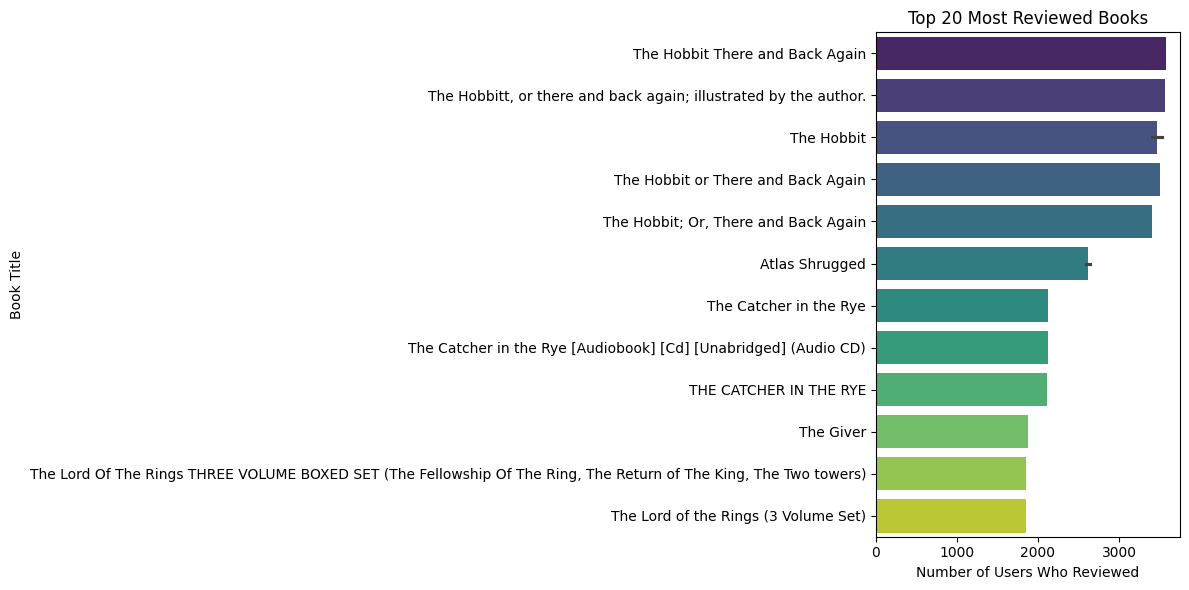

In [20]:
# Top 20 most reviewed books (raw frequency after pruning)
top_books = pd.Series([b for lst in baskets["books"] for b in lst]).value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_books.values, y=[id2title.get(i, str(i)) for i in top_books.index], palette="viridis")
plt.title("Top 20 Most Reviewed Books")
plt.xlabel("Number of Users Who Reviewed")
plt.ylabel("Book Title")
plt.tight_layout()
plt.show()



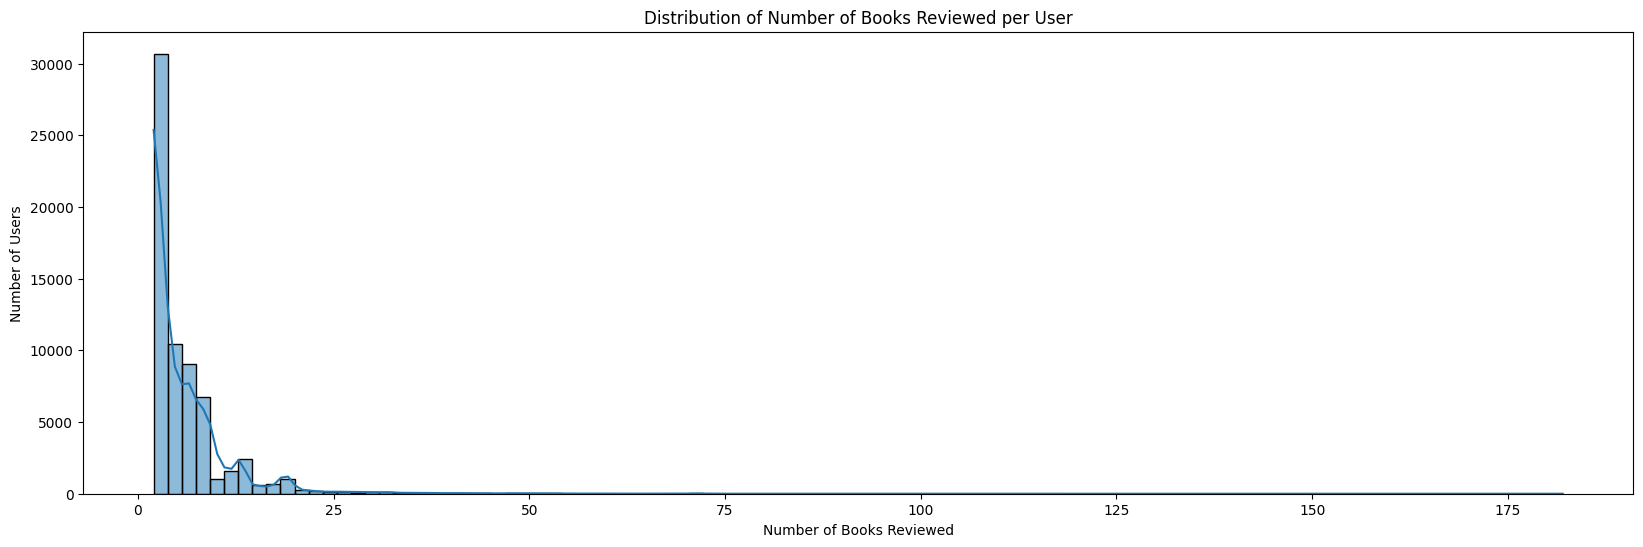

In [21]:
# Distribution of number of books per user
plt.figure(figsize=(20, 6))
sns.histplot(baskets['books'].map(len), bins=100, kde=True)
plt.title('Distribution of Number of Books Reviewed per User')
plt.xlabel('Number of Books Reviewed')
plt.ylabel('Number of Users')
plt.show()

/tmp/ipython-input-1703415099.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


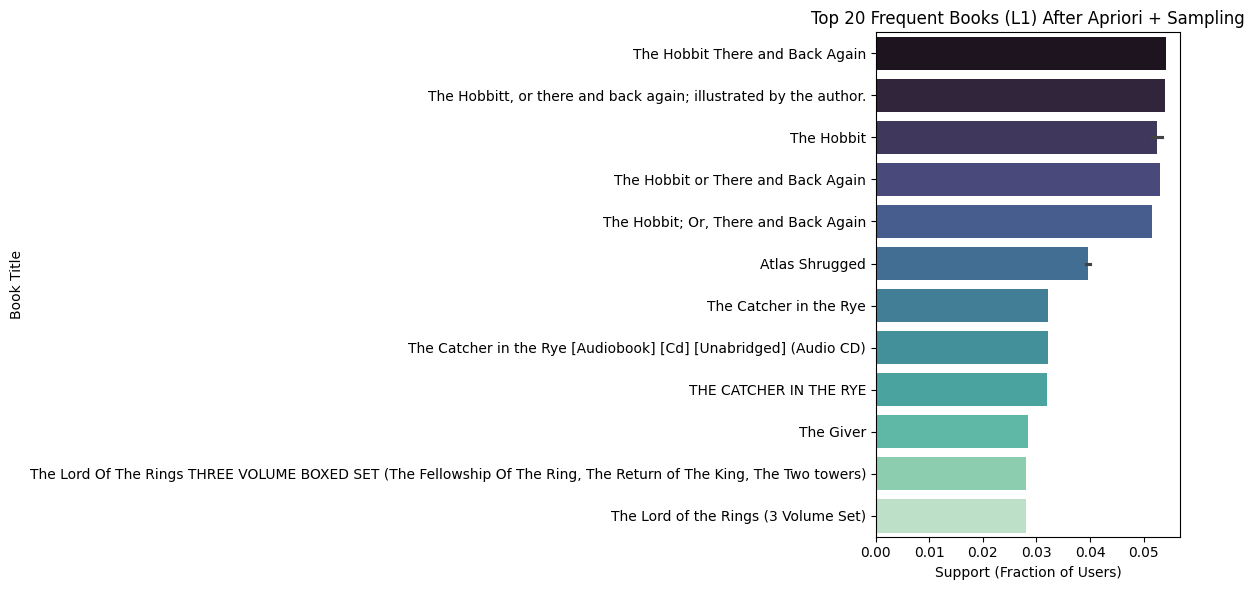

In [22]:
# Top 20 frequent books by support (L1)
top_freq_items = pd.DataFrame({
    "item": list(L1_full),
    "support": [supp1_full[i] for i in L1_full]
}).sort_values("support", ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(
    x=top_freq_items["support"],
    y=[id2title.get(i, str(i)) for i in top_freq_items["item"]],
    palette="mako"
)
plt.title("Top 20 Frequent Books (L1) After Apriori + Sampling")
plt.xlabel("Support (Fraction of Users)")
plt.ylabel("Book Title")
plt.tight_layout()
plt.show()

/tmp/ipython-input-696801551.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


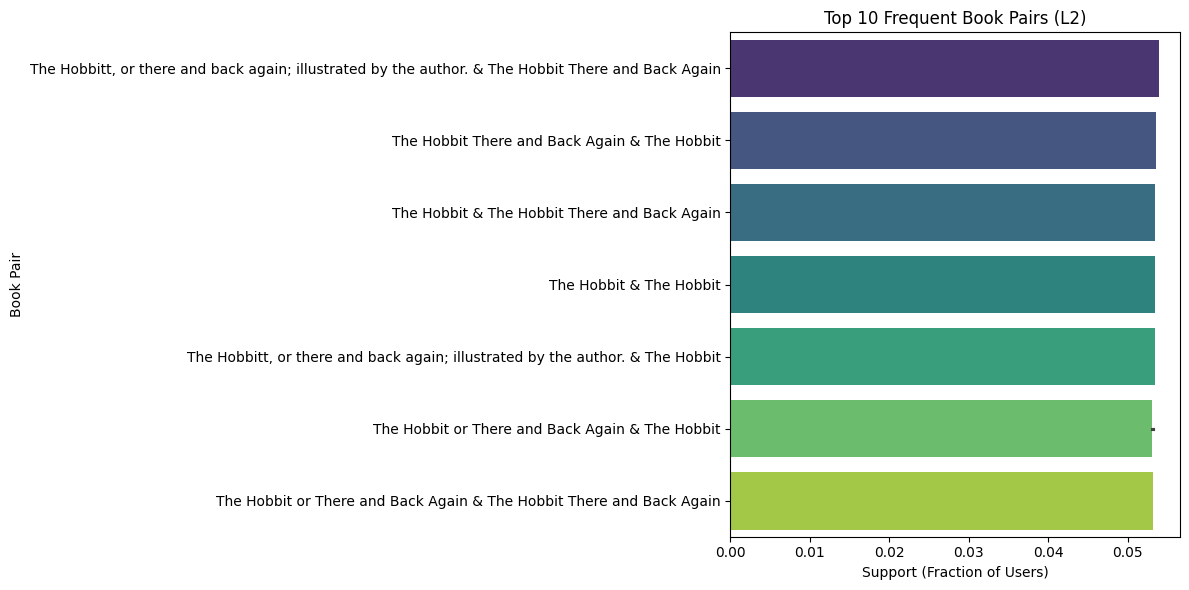

In [23]:
# Top 10 frequent pairs by support (L2)
pairs_df = pd.DataFrame([
    {"pair": tuple(pair), "support": supp}
    for pair, supp in L2_full.items()
]).sort_values("support", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(
    x=pairs_df["support"],
    y=[id2title.get(p[0], str(p[0])) + " & " + id2title.get(p[1], str(p[1]))
       for p in pairs_df["pair"]],
    palette="viridis"
)
plt.title("Top 10 Frequent Book Pairs (L2)")
plt.xlabel("Support (Fraction of Users)")
plt.ylabel("Book Pair")
plt.tight_layout()
plt.show()
